In [13]:
import tensorflow as tf
import tensorflow.keras as ks
import numpy as np
import scipy.stats as sp
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.utils import shuffle
from keras import backend as K

In [14]:
full_data = np.genfromtxt('/Users/matthiasfallon/Desktop/QSAR-monomer-reactivity-prediction-main/datafiles/Udatatest.csv', delimiter= ',', skip_header=1)

In [15]:
print(full_data)

[ 1.33 -1.88  1.73 -2.75  1.56 -1.82 -2.39 -2.13 -2.68 -2.22 -1.99 -2.34
  3.01 -3.01  2.38 -1.55 -1.09 -2.6   3.5  -0.37 -0.39 -0.08 -3.5  -0.38
 -2.   -2.18 -1.32 -2.18 -2.57 -0.3  -0.25 -2.74 -2.77 -2.33 -2.74 -2.38
 -1.96 -2.03 -0.77 -0.74 -2.6  -2.6  -1.57 -4.05 -4.31 -2.39 -2.5  -2.51
 -1.44 -0.32  0.14 -1.91 -2.51 -5.2   4.23 -1.26  1.97 -1.39 -1.45  1.04
 -1.4  -1.49  1.32 -1.43 -1.18 -2.22 -0.95 -1.98 -2.08 -2.08 -0.83 -1.03
 -0.33 -2.35 -1.04 -0.2  -0.98 -0.94 -1.98  0.41 -0.6  -0.44 -0.62 -0.2
  0.    0.75 -0.78 -0.4  -0.49  1.18 -0.44 -0.86 -0.66 -0.82  0.14 -0.9
 -0.98 -1.58 -0.98  0.44  1.11 -1.11  0.66 -0.12 -0.34  0.41  0.18  0.29
 -1.56  2.46 -2.23  0.2  -1.19  0.14  0.41 -1.03 -1.03  1.34  0.29 -1.41]


In [16]:
full_data = full_data.reshape(-1, 1)
training_set = full_data[:,:7]
training_targets = full_data[:,:8]
##normalizing data
mean = training_set.mean(axis=0)
training_set -= mean
std = training_set.std(axis=0)
training_set /= std

print(training_set, training_targets)

[[ 1.47262469e+00]
 [-6.07671007e-01]
 [ 1.73185157e+00]
 [-1.17148947e+00]
 [ 1.62168015e+00]
 [-5.68786976e-01]
 [-9.38185277e-01]
 [-7.69687807e-01]
 [-1.12612476e+00]
 [-8.28013854e-01]
 [-6.78958399e-01]
 [-9.05781918e-01]
 [ 2.56137758e+00]
 [-1.33998694e+00]
 [ 2.15309525e+00]
 [-3.93808833e-01]
 [-9.56979226e-02]
 [-1.07427939e+00]
 [ 2.87893051e+00]
 [ 3.70910459e-01]
 [ 3.57949115e-01]
 [ 5.58849945e-01]
 [-1.65753987e+00]
 [ 3.64429787e-01]
 [-6.85439071e-01]
 [-8.02091166e-01]
 [-2.44753378e-01]
 [-8.02091166e-01]
 [-1.05483737e+00]
 [ 4.16275162e-01]
 [ 4.48678522e-01]
 [-1.16500880e+00]
 [-1.18445081e+00]
 [-8.99301246e-01]
 [-1.16500880e+00]
 [-9.31704606e-01]
 [-6.59516383e-01]
 [-7.04881087e-01]
 [ 1.11683580e-01]
 [ 1.31125596e-01]
 [-1.07427939e+00]
 [-1.07427939e+00]
 [-4.06770177e-01]
 [-2.01397682e+00]
 [-2.18247429e+00]
 [-9.38185277e-01]
 [-1.00947267e+00]
 [-1.01595334e+00]
 [-3.22521441e-01]
 [ 4.03313818e-01]
 [ 7.01424729e-01]
 [-6.27113023e-01]
 [-1.0159533

In [17]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [18]:
avg_scores = []
epochs = []
avg_scores.clear()
epochs.clear()

In [19]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu',
                           input_shape=(training_set.shape[1],)))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=[coeff_determination])
    return model

In [20]:
# Disabling iteration warning
tf.get_logger().setLevel('ERROR')

# Establishing parameters
iterations = 4
folds = 5
epochs1 = 100
samples = len(training_set) // folds
test_scores = []

for i in range(iterations):
        # Shuffling data
        training_set, training_targets = shuffle(training_set, training_targets)

        for k in range(folds):
            # Running folds
            print('processing iteration #', i, 'fold #', k)
            # Preping validation data from partition k
            val_data = training_set[i * samples: (i + 1) * samples]
            val_targets = training_targets[i * samples: (i + 1) * samples]

            # Preping training data
            partial_training_data = np.concatenate([training_set[:i * samples],
                                                    training_set[(i + 1) * samples:]],
                                                   axis=0)
            partial_training_targets = np.concatenate([training_targets[:i * samples],
                                                       training_targets[(i + 1) * samples:]],
                                                      axis=0)
            # Building model
            model = build_model()
            # Training
            model.fit(partial_training_data, partial_training_targets, epochs=epochs1, batch_size=1, verbose=0)
            # Eval model
            val_mse, val_r2 = model.evaluate(val_data, val_targets, verbose=0)
            test_scores.append(val_r2)

print(test_scores)
print(np.mean(test_scores))

processing iteration # 0 fold # 0
processing iteration # 0 fold # 1
processing iteration # 0 fold # 2
processing iteration # 0 fold # 3
processing iteration # 0 fold # 4
processing iteration # 1 fold # 0
processing iteration # 1 fold # 1
processing iteration # 1 fold # 2
processing iteration # 1 fold # 3
processing iteration # 1 fold # 4
processing iteration # 2 fold # 0
processing iteration # 2 fold # 1
processing iteration # 2 fold # 2
processing iteration # 2 fold # 3
processing iteration # 2 fold # 4
processing iteration # 3 fold # 0
processing iteration # 3 fold # 1
processing iteration # 3 fold # 2
processing iteration # 3 fold # 3
processing iteration # 3 fold # 4
[0.9999322891235352, 0.9995074272155762, 0.9997271299362183, 0.9994828104972839, 0.999776303768158, 0.9909926652908325, 0.9998476505279541, 0.991941511631012, 0.9999959468841553, 0.9843964576721191, 0.9999539852142334, 0.999996542930603, 0.9999900460243225, 0.9999778866767883, 0.9999894499778748, 0.9998092651367188, 0.

In [22]:
I = 4
k = 5
num_val_samples = len(training_set) // k
num_epochs = 0
all_scores = np.zeros((I,k))
epochs = []
avg_scores = []
## epochs
for l in range(0, 100, 10):
    print(l)
    num_epochs = l
    
    ## iterations
    for i in range(I):
    
        ##shuffle
        training_set, training_targets = shuffle(training_set, training_targets)
        epochs.append(num_epochs)
        ##kfold
        for j in range(k):
            print('processing fold #', i, j)
            ##preping validation data from partition k
            val_data = training_set[i * num_val_samples: (i + 1) * num_val_samples]
            val_targets = training_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
            ##preping training data
            partial_training_data = np.concatenate(
                [training_set[:i * num_val_samples], training_set[(i + 1) * num_val_samples:]],
                axis=0)
            partial_training_targets = np.concatenate([training_targets[:i * num_val_samples],
                                                       training_targets[(i + 1) * num_val_samples:]],
                axis=0)
            ##building model
            model = build_model()
            ##training
            model.fit(partial_training_data, partial_training_targets, epochs=num_epochs, 
                     batch_size=1, verbose=0)
            ##eval model
            val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
            all_scores[i,j] = val_mae
        
   
    avg_scores.append(np.mean(all_scores))
    K.clear_session()

0
processing fold # 0 0
processing fold # 0 1
processing fold # 0 2
processing fold # 0 3
processing fold # 0 4
processing fold # 1 0
processing fold # 1 1
processing fold # 1 2
processing fold # 1 3
processing fold # 1 4
processing fold # 2 0
processing fold # 2 1
processing fold # 2 2
processing fold # 2 3
processing fold # 2 4
processing fold # 3 0
processing fold # 3 1
processing fold # 3 2
processing fold # 3 3
processing fold # 3 4
10
processing fold # 0 0
processing fold # 0 1
processing fold # 0 2
processing fold # 0 3
processing fold # 0 4
processing fold # 1 0
processing fold # 1 1
processing fold # 1 2
processing fold # 1 3
processing fold # 1 4
processing fold # 2 0
processing fold # 2 1
processing fold # 2 2
processing fold # 2 3
processing fold # 2 4
processing fold # 3 0
processing fold # 3 1
processing fold # 3 2
processing fold # 3 3
processing fold # 3 4
20
processing fold # 0 0
processing fold # 0 1
processing fold # 0 2
processing fold # 0 3
processing fold # 0 4
pr

In [23]:
np.savetxt('epochs_mse.csv', avg_scores, delimiter = ',')

In [27]:
print(avg_scores)
len(avg_scores)
epochs = range(0, 100, 10)
len(epochs)

[0.038123100996017456, 0.9805604517459869, 0.996042799949646, 0.9932725429534912, 0.9990058183670044, 0.9996999651193619, 0.9986872017383576, 0.9993451863527298, 0.9998387157917022, 0.9997510135173797]


10

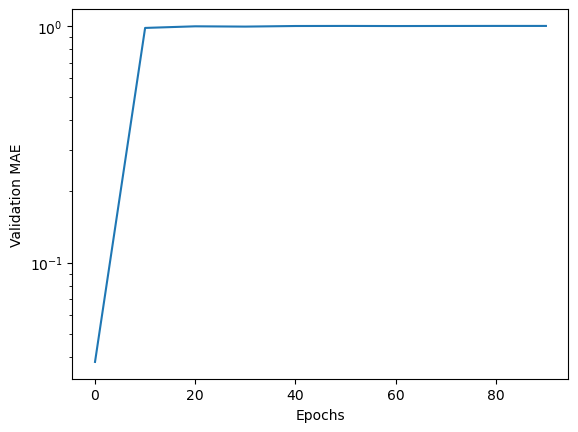

<Figure size 640x480 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
plt.yscale("log")
plt.plot(epochs, avg_scores)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()
plt.savefig('epochs_unsmothed')

In [26]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


In [29]:
sm_score = smooth_curve(avg_scores)

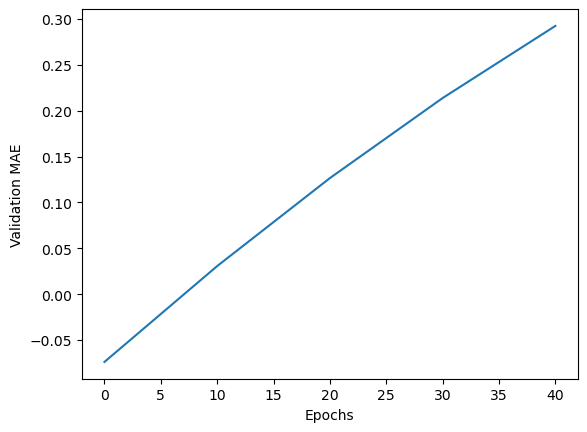

In [31]:
plt.figure()
plt.plot(range(0, 50, 10), sm_score)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.savefig('V_epoch.png', dpi=600)